## Introduction to Singular Value Decomposition
This is a technique that is used take any matrix, even an non-invertible and non-square matrix and break it down into three matrices, where two of them are orthogonal matrices and one is an diagonal matrix. More formally for every given matrix $A$ of the form $m\times n$ can be written in the form $U\Sigma V^T$ where $U$ is a $m\times m$ orthogonal matrix, $\Sigma $ is a $m\times n $ diagonal matrix composed of positive values, and $V$ is a $n\times n$ orthogonal matrix. 
  
Intuitively this makes sense because its hard to imagine a linear transformation that can't be expressed as a rotation, scaling and then another rotation. But finding this decomposition is not super simple.
  
The first step of this process is to take the matrix we want to compress $A$ and calculate $A^TA$. This creates a square matrix which is really convient because it allows us to calculate the eigenvalues and eigenvectors. We calculate the eigenvalues and eigenvectors of $A^TA$ and sort them in descending order by their eigenvalues. With this we can calculate both $V$ and $\Sigma$. $V$ is simply the matrix of eigenvectors and $\Sigma$ is a diagonal matrix where the diagonal elements are the square roots of the eigenvalues. Now all thats left is to calculate $U$. We calculate $U$ by applying $A$ to each of the eigenvectors in $V$ and normalizing them. Thus we have calculated $U\Sigma V$ which equals $A$.
  
Now you might be wondering why we would want to do this. It seems like turning a matrix into three matrices is a step away from anything useful. But now we can actually modulate the quality of the image by changing the number of singular values that we use. For example if we want if we want to compress an image and transform it into the form $U\Sigma V$, we can choose to only use the first $n$ columns of $U$ and $V$ and the first $n$ rows/columns of $\Sigma$. This gives us a compressed verion of the image that is still recognizable. If your data is senstive it is important to note that this is not a lossless compression technique and is not reccomended for extremely sensitive data. 

<br>
<br>
<br>
<br>


For the first part of this code we need to make a function which returns the three matrices $U$, $\Sigma$ and $V$.  
  
In order to do this we need to calculate out the eigenvalues and eigenvectors of $A^TA$. This is a super computationally expensive task so we are going to use the optimized numpy linear algebra library to do this 
  
This is a super computationally expensive operation so we are going to use the optimized numpy linear algebra library to do this. There are two different functions that can do this for us. The first is the numpy.linalg.eig function which finds eigenvalues and eigenvector on any square matrix, it used a QR decomposition algorithm to do so. The second is the numpy.linalg.eigh which is optimized to work specifically on symmetric matrices, and thus utilizes a divide and conquer algorithm to do so. The eigh function actually had some problems with rounding errors that made image look insane so we are going to use the eig function instead. Within this folder is the insane looking image if you want to see it. 

In [14]:
import numpy as np
from numpy.linalg import eig

def svd(A):
    #finds the eigenvalues and eigenvectors of A.T @ A
    ev, V = eig(A.T @ A)
    
    #make sure that every eigenvalue is non-negative, it shouldn't be because A.T @ A is positive semi-definite, but rounding errors might lead to negative eigenvalues
    ev = np.maximum(ev, 1e-10)  

    #sort the eigenvalues and eigenvectors in descending order
    idx = np.argsort(ev)[::-1]
    ev = ev[idx]
    V = V[:, idx]
    

    #gets the square root of every eigenvalue
    singular_values = np.sqrt(ev)  

    #find the number of singular values
    rank = len(singular_values)

    #initalize the U matrix
    U = np.zeros((A.shape[0], rank))

    #we normalize each eigenvector of 
    for i in range(rank):
        U[:, i] = A @ (V[:, i] / singular_values[i])

    #initalize the Sigma matrix as a square matrix and fill the diagonal with singular values
    Sigma = np.zeros((rank, rank), dtype=float)
    np.fill_diagonal(Sigma, singular_values[:rank])

    return U, Sigma, V

# Test the updated SVD function
def generate_random_matrix(m, n):
    return np.random.randint(-10, 10, (m, n))

A = generate_random_matrix(5, 3)
print("Original matrix:\n", A)

U, Sigma, V = svd(A)
print("U:\n", U)
print("Sigma:\n", Sigma)
print("V:\n", V)
print("Reconstructed matrix:\n", U @ Sigma @ V.T)


Original matrix:
 [[  4   6   9]
 [  9  -9   8]
 [  4  -6   4]
 [ -3 -10 -10]
 [  0   0   2]]
U:
 [[ 0.56535671  0.23849486  0.10216559]
 [ 0.48254082 -0.72004271  0.30032019]
 [ 0.21202976 -0.43457946 -0.48439646]
 [-0.6283003  -0.48557748  0.04461869]
 [ 0.08836435 -0.00372745 -0.81408797]]
Sigma:
 [[19.18176133  0.          0.        ]
 [ 0.         16.44278374  0.        ]
 [ 0.          0.          1.30188132]]
V:
 [[ 0.48678085 -0.35322428  0.79892241]
 [ 0.21166447  0.93503663  0.28443742]
 [ 0.84749192 -0.0306448  -0.52992296]]
Reconstructed matrix:
 [[ 4.00000000e+00  6.00000000e+00  9.00000000e+00]
 [ 9.00000000e+00 -9.00000000e+00  8.00000000e+00]
 [ 4.00000000e+00 -6.00000000e+00  4.00000000e+00]
 [-3.00000000e+00 -1.00000000e+01 -1.00000000e+01]
 [ 2.64963409e-16 -3.52379281e-16  2.00000000e+00]]


Now that we have verified that it worked we can move onto an actual image. We are going to start small with a $28 \times 28$ size image from the MNIST dataset. We make it into a matrix by just considering each pixel as a value in a matrix. We then calculate the SVD of this matrix and the see how different numbers of singular values effect the image.

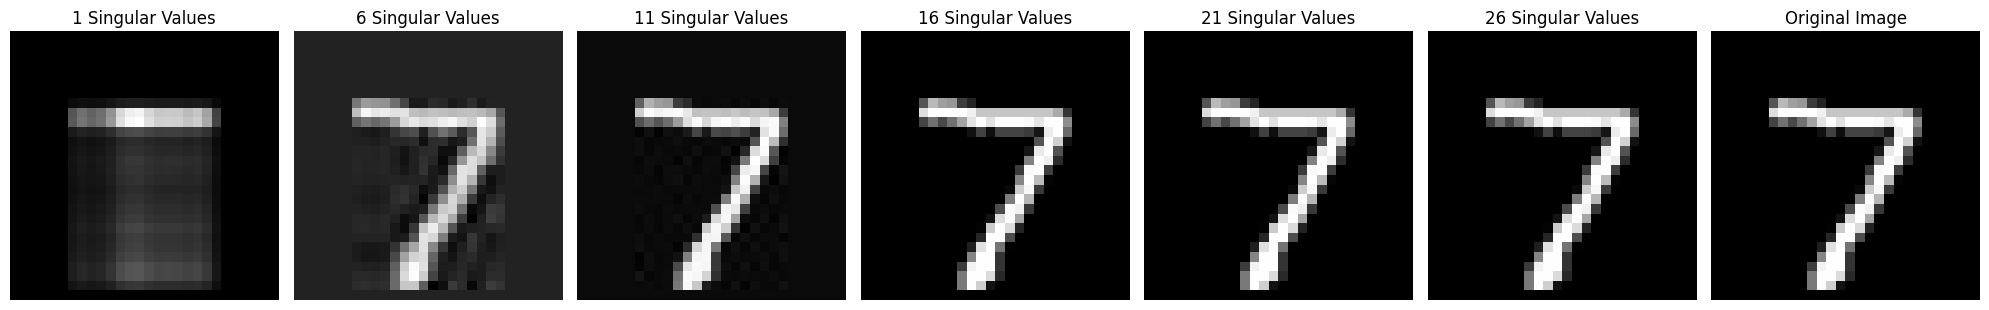

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys 

data = pd.read_csv('MNIST.csv', header=None)
image_matrix = np.array(data)



U, Sigma, V = svd(image_matrix)


step = 5
num_singular_values = image_matrix.shape[0]
display_values = [i for i in range(1, num_singular_values + 1, step)]

def chop_matrices(U, Sigma, V, n):
    U_n = U[:, :n] 
    Sigma_n = Sigma[:n, :n]  
    V_n = V[:, :n] 
    return U_n @ Sigma_n @ V_n.T



fig, axes = plt.subplots(1, len(display_values) + 1, figsize=(20, 20))  # Add +1 to accommodate the original image

for i in range(len(display_values)):
    reconstructed_image = chop_matrices(U, Sigma, V, display_values[i])
    axes[i].imshow(reconstructed_image, cmap='gray')
    axes[i].set_title(f'{display_values[i]} Singular Values')
    axes[i].axis('off')

axes[len(display_values)].imshow(image_matrix, cmap='gray')  # Use len(display_values) for the original image
axes[len(display_values)].set_title('Original Image')
axes[len(display_values)].axis('off')

plt.tight_layout()
plt.show()


Now we are going to move onto a larger image. We aren't going to deal with color instead we are dealing with a grayscale image. We can see beneath how the different number of singular values effect the image.

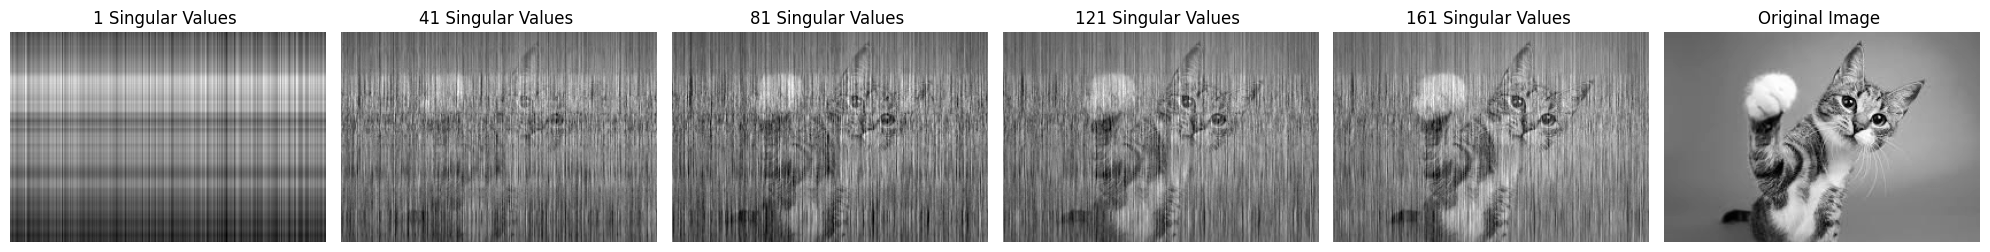

In [17]:
from PIL import Image
image_path = 'Cat_image.jpg'
image = Image.open(image_path)

image_gray = image.convert('L')


image_array = np.array(image_gray)

step = 40
num_singular_values = image_array.shape[0]
display_values = [i for i in range(1, num_singular_values + 1, step)]
U, Sigma, V = svd(image_array)


fig, axes = plt.subplots(1, len(display_values) + 1, figsize=(20, 20))  # Add +1 to accommodate the original image

for i in range(len(display_values)):
    reconstructed_image = chop_matrices(U, Sigma, V, display_values[i])
    axes[i].imshow(reconstructed_image, cmap='gray')
    axes[i].set_title(f'{display_values[i]} Singular Values ')
    axes[i].axis('off')

axes[len(display_values)].imshow(image_array, cmap='gray')  # Use len(display_values) for the original image
axes[len(display_values)].set_title('Original Image ')
axes[len(display_values)].axis('off')

plt.tight_layout()
plt.show()




This process is pretty much the same but now we are going to do this with a color image. We can do this by breaking it into color channels one from Red, Green and Blue. We can then calculate the SVD of each of these channels and then combine them back together to get the original image.

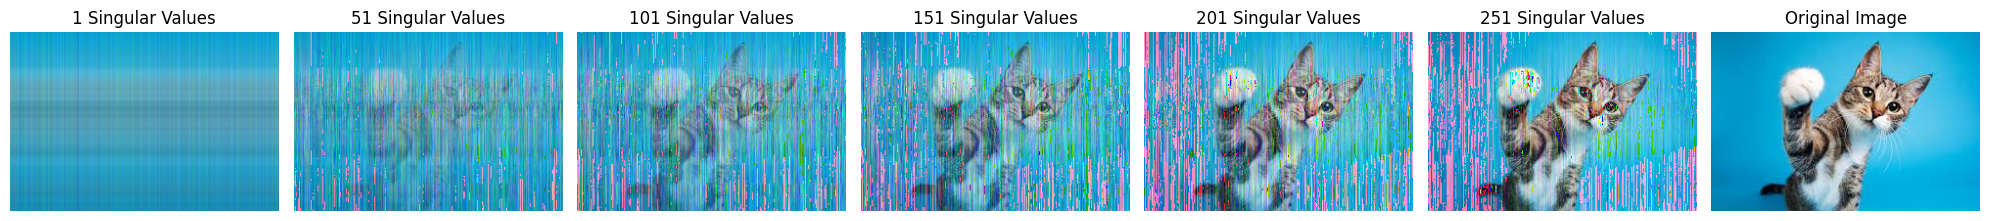

In [18]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

image_path = 'Cat_image.jpg'
image = Image.open(image_path)

# Convert image to numpy array
image_array = np.array(image)
channel_matrices = []

def chop_matrices(U, Sigma, V, n):
    U_n = U[:, :n] 
    Sigma_n = Sigma[:n, :n]  
    V_n = V[:, :n] 
    return U_n @ Sigma_n @ V_n.T

# Compute SVD for each color channel
for i in range(3):
    channel = image_array[:, :, i]
    U, Sigma, V = svd(channel)  # Use compact SVD
    channel_matrices.append((U, Sigma, V))

# Define singular value steps
step = 50
num_singular_values = channel_matrices[0][1].shape[0]
display_values = [i for i in range(1, num_singular_values + 1, step)]

fig, axes = plt.subplots(1, len(display_values) + 1, figsize=(20, 20))

# Display compressed images first
for j, n in enumerate(display_values):
    compressed_channels = []
    for i in range(3):
        U, Sigma, V = channel_matrices[i]
        compressed_channels.append(chop_matrices(U, Sigma, V, n))
    
    # Stack channels back together
    compressed_image = np.stack(compressed_channels, axis=2).astype(np.uint8)
    
    # Plot compressed image
    axes[j].imshow(compressed_image)
    axes[j].set_title(f"{n} Singular Values")
    axes[j].axis("off")

# Display the original image last
axes[-1].imshow(image)
axes[-1].set_title("Original Image")
axes[-1].axis("off")

plt.tight_layout()
plt.show()
